In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torchvision.transforms as T 
import torch.utils.data as Data
from PIL import Image
import os
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib import image
import csv 
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available(),torch.cuda.current_device()

(True, 0)

In [2]:
from torch.autograd import variable

# importing data

In [18]:
S=np.load('F:/Linetrack_project/samples/ki/data.npy')#F:/Linetrack_project/samples/fi/data2.npy
A=np.load('F:/Linetrack_project/samples/ki/label.npy')#F:/Linetrack_project/samples/fi/data2.npy
A=A.astype(int)
print(A.shape,S.shape)
#st_train=S[:500,:]
#at_train=A[:500]
#st_v=S[500:,:]
#at_v=A[500:]
idx1 = np.random.choice(A.shape[0], size=600, replace=False, p=None)
st_train = S[idx1,:]
at_train=A[idx1]
idx2=np.ones(A.shape)
idx2[idx1]=0
st_v=S[idx2==1,:]
at_v=A[idx2==1]
print(st_v.shape,st_train .shape)

(797,) (797, 3, 100, 130)
(197, 3, 100, 130) (600, 3, 100, 130)


In [3]:
A

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
#st_v=np.load('F:/Linetrack_project/samples/seq6/data.npy') 
#at_v=np.load('F:/Linetrack_project/samples/seq6/label.npy') 
#at_v=at_v.astype(int)
S=torch.tensor(st_train, dtype=torch.float32).cuda()
A=torch.tensor(at_train, dtype=torch.int32).cuda()
_st=torch.tensor(st_v, dtype=torch.float32).cuda().detach()
_at=torch.tensor(at_v, dtype=torch.int32).cuda().detach()

torch_dataset=Data.TensorDataset (S,A)
loader =Data.DataLoader(dataset = torch_dataset, batch_size=128, shuffle=True)# num_workers=2

# 网络 networks

In [5]:
print(A.shape)

torch.Size([500])


In [22]:
class DQN(nn.Module):##集成nn.Module 里面的方法，eg:eval()

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()####super() 函数是用于调用父类(超类)的一个方法。
        self.conv1 = nn.Conv2d(3 , 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)####normalize.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.drop= nn.Dropout()

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))

        linear_input_size = convw * convh * 64
        self.head1 = nn.Linear(linear_input_size, 100)## output为n_actions的个数。
        self.head2 = nn.Linear(100, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.drop(self.bn1(self.conv1(x))))#.detach()
        x = F.relu(self.drop(self.bn2(self.conv2(x))))#.detach()
        x = F.relu(self.drop(self.bn3(self.conv3(x))))#.detach()
        return self.head2(self.drop(self.head1(x.view(x.size(0), -1))))

# 算法 algorithm

In [4]:
policy_net = DQN(250,300,2).to(device)
for param in policy_net.parameters():
    print(param.shape)

torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([100, 60928])
torch.Size([100])
torch.Size([2, 100])
torch.Size([2])


In [23]:
#hyperperameters
epochs=500
screen_height=100
screen_width=130##130
#batch_size=10
acc_v=torch.zeros((epochs))
acc_t=torch.zeros((epochs))
policy_net = DQN(screen_height, screen_width,4).to(device)
optimizer = optim.Adam(policy_net.parameters())#RMSprop
policy_net.train()
i=0
import time 
tic=time.time()
num=1
for epoch in range(epochs):
    for step,(st,at) in enumerate (loader):
        policy_net.train()
        y_pred=policy_net(st)

        cri = nn.CrossEntropyLoss()
        loss=cri(y_pred,at.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    policy_net.eval()
    y_pred1=torch.argmax(policy_net(_st),1)
    
    acc=torch.sum(_at.long()==y_pred1.long()).item()/len(_at)
    print('|epoch',epoch,'|loss:',loss,'|accuracy:',acc)
    if epoch%100==99:
        torch.save(policy_net.state_dict(),'F:/Linetrack_project/samples/fii/model%s.h5'%int(num))
        num+=1
    acc_v[epoch]=1-acc
    #if acc>=0.97:
        #break
    y_pred2=policy_net(S)
    y_pred2=torch.argmax(policy_net(S),1)
    acc=torch.sum(A.long()==y_pred2.long()).item()/len(A.long())
    #print('|epoch',epoch,'|loss:',loss,'|accuracy:',acc)
    acc_t[epoch]=acc
    
toc=time.time()
print('time:',toc-tic)#RMSprop

|epoch 0 |loss: tensor(0.9547, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.751269035532995
|epoch 1 |loss: tensor(0.3885, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.868020304568528
|epoch 2 |loss: tensor(0.4551, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9390862944162437
|epoch 3 |loss: tensor(0.2163, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9390862944162437
|epoch 4 |loss: tensor(0.1719, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.949238578680203
|epoch 5 |loss: tensor(0.1880, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.949238578680203
|epoch 6 |loss: tensor(0.1229, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.949238578680203
|epoch 7 |loss: tensor(0.0989, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9796954314720813
|epoch 8 |loss: tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9796954314720813
|epoch 9 |loss: tensor(0.0687, device='cuda:0', grad_fn=<Nll

|epoch 82 |loss: tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9847715736040609
|epoch 83 |loss: tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 84 |loss: tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 1.0
|epoch 85 |loss: tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 86 |loss: tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 1.0
|epoch 87 |loss: tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 1.0
|epoch 88 |loss: tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 89 |loss: tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 90 |loss: tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 91 |loss: tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 1.0


|epoch 162 |loss: tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9543147208121827
|epoch 163 |loss: tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 164 |loss: tensor(0.0451, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 165 |loss: tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9847715736040609
|epoch 166 |loss: tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9441624365482234
|epoch 167 |loss: tensor(0.0129, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9746192893401016
|epoch 168 |loss: tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 169 |loss: tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 1.0
|epoch 170 |loss: tensor(4.4172e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 171 |loss: tensor(0.0005, device='cuda:0'

|epoch 240 |loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9796954314720813
|epoch 241 |loss: tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9796954314720813
|epoch 242 |loss: tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.8527918781725888
|epoch 243 |loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.8324873096446701
|epoch 244 |loss: tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9746192893401016
|epoch 245 |loss: tensor(8.4639e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 246 |loss: tensor(9.7004e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 247 |loss: tensor(1.6776e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 248 |loss: tensor(2.7841e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 249 |loss: ten

|epoch 319 |loss: tensor(8.9949e-07, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 320 |loss: tensor(1.8282e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 321 |loss: tensor(3.1135e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 322 |loss: tensor(2.5294e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 323 |loss: tensor(3.7172e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 324 |loss: tensor(1.2257e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 325 |loss: tensor(3.5178e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 326 |loss: tensor(7.1970e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 327 |loss: tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoc

|epoch 398 |loss: tensor(2.9802e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 399 |loss: tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 400 |loss: tensor(9.0339e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 1.0
|epoch 401 |loss: tensor(3.3053e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 402 |loss: tensor(2.2249e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9898477157360406
|epoch 403 |loss: tensor(0.0307, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9847715736040609
|epoch 404 |loss: tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9847715736040609
|epoch 405 |loss: tensor(3.5817e-05, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.7969543147208121
|epoch 406 |loss: tensor(5.4945e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.7157360406091371
|epoch 407 |loss: tensor(0.0

|epoch 475 |loss: tensor(3.0127e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 476 |loss: tensor(0., device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 477 |loss: tensor(1.9399e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 478 |loss: tensor(1.0512e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 479 |loss: tensor(1.8207e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 480 |loss: tensor(4.1940e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 481 |loss: tensor(3.1645e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 482 |loss: tensor(2.5793e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 483 |loss: tensor(7.4452e-06, device='cuda:0', grad_fn=<NllLossBackward>) |accuracy: 0.9949238578680203
|epoch 48

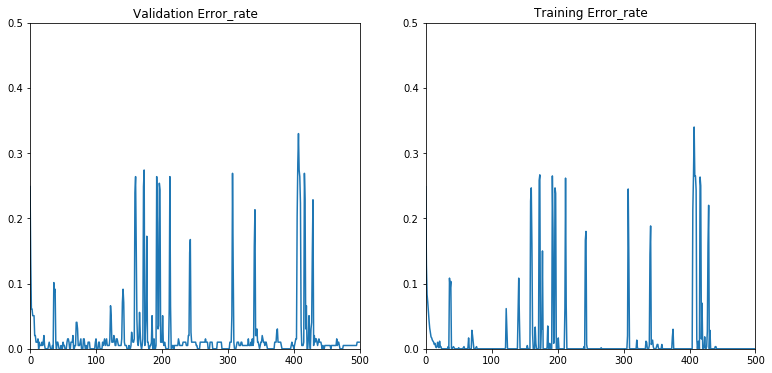

In [29]:
plt.subplot(1,2,1)
plt.title('Validation Error_rate')
plt.axis([0, epochs, 0, 0.5])
plt.plot(np.array(range(epochs)),acc_v.numpy())
plt.subplot(1,2,2)
plt.title('Training Error_rate')
plt.axis([0, epochs, 0, 0.5])
plt.gcf().set_size_inches(13, 6)
plt.plot(np.array(range(epochs)),(1-acc_t.numpy()))
#plt.savefig('F:/Linetrack_project/results/loss/loss%s.jpg'%(664))

In [42]:
torch.save(policy_net.state_dict(), '/Users/ABCQMARS/Desktop/model3.h5')

In [30]:
policy_net = DQN(250,300,2).to(device)
save_path='/Users/ABCQMARS/Desktop/model1.h5'
policy_net.load_state_dict({k.replace('module.',''):v for k,v in torch.load(save_path).items()})
#policy_net.load_state_dict(torch.load('/Users/ABCQMARS/Desktop/model1.h5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# 错误样本检验wrongly analysed sample reexamination

In [19]:
#找到测试样本索引finding the index of the samples
policy_net.eval()
imgs=np.load('F:/Linetrack_project/samples/fii/data2.npy') 
val_idx=np.array(range(imgs.shape[0]))
print(val_idx.shape,idx2.shape)
val_idx=val_idx[idx2==1]
#找到错误样本
y_pred1=policy_net(_st)
y_pred1=torch.argmax(policy_net(_st),1)
F_idx=val_idx[_at.cpu().long().numpy()!=y_pred1.cpu().long().numpy()]

#找到错误的标ji

(2083,) (2083,)


In [20]:
S=np.load('F:/Linetrack_project/samples/fii/data2.npy') 
S=torch.tensor(S, dtype=torch.float32).cuda()
A=np.load('F:/Linetrack_project/samples/fii/label2.npy') 
label_pred=torch.argmax(policy_net(S),1)
label_pred.shape

torch.Size([2083])

In [21]:
#图像还原展示。
for i in F_idx:
    im=imgs[i,:]
    im=np.transpose(im,[1,2,0])
    im=im.astype(np.uint8)
    print('序号',i+1,'输出标记:',label_pred[i].cpu().numpy(),'真实标记:',A[i])
    cv2.imshow('im',im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

序号 20 输出标记: 1 真实标记: 0
序号 106 输出标记: 0 真实标记: 2
序号 217 输出标记: 4 真实标记: 0
序号 219 输出标记: 0 真实标记: 4
序号 223 输出标记: 0 真实标记: 4
序号 230 输出标记: 0 真实标记: 4
序号 239 输出标记: 0 真实标记: 4
序号 250 输出标记: 0 真实标记: 4
序号 253 输出标记: 4 真实标记: 0
序号 483 输出标记: 2 真实标记: 0
序号 520 输出标记: 2 真实标记: 0
序号 1748 输出标记: 0 真实标记: 2
序号 1830 输出标记: 0 真实标记: 2
序号 1842 输出标记: 0 真实标记: 2
序号 1901 输出标记: 0 真实标记: 2
序号 1902 输出标记: 0 真实标记: 2


# changing label

In [453]:
label=pd.read_csv('F:/Linetrack_project/samples/seq7/label.csv',header= None,error_bad_lines=False)
label=label.values
label=label[:,0]
print(label.shape)
np.save('F:/Linetrack_project/samples/seq7/label.npy',label) 

(300,)


# testing the prediction of individual pictures

uint8
0.0019958019256591797
tensor([1], device='cuda:0')


C:\Users\ABCQMARS\Anaconda3\lib\site-packages\torch\autograd\__init__.py:171: UserWarning: torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead
  warnings.warn("torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead")
C:\Users\ABCQMARS\Anaconda3\lib\site-packages\torch\autograd\__init__.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(*args, **kwargs)


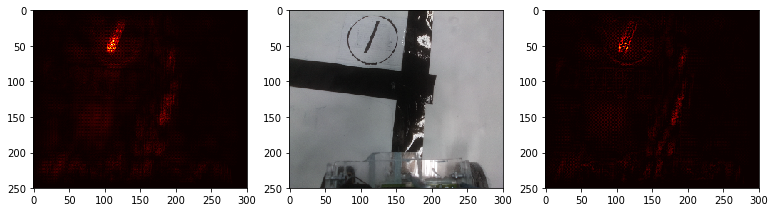

In [38]:
#policy_net = DQN(100,130,2).to(device)
policy_net = DQN(250,300,2).to(device)
save_path='/Users/ABCQMARS/Desktop/model5.h5'
policy_net.load_state_dict({k.replace('module.',''):v for k,v in torch.load(save_path).items()})
#policy_net.load_state_dict(torch.load('/Users/ABCQMARS/Desktop/model1.h5'))
#policy_net.load_state_dict(torch.load('/Users/ABCQMARS/Desktop/model3.h5'))
policy_net.eval()
im=cv2.imread('C:/Users/ABCQMARS/Desktop/183.jpg')
im=cv2.resize(im,(300,250))
print(im.dtype)

a=np.array(im)
a=a.astype(np.float64)
a=np.transpose(a,[2,0,1])
a=a[np.newaxis,:]
i=torch.tensor(a, dtype=torch.float32).cuda()
i=variable(i,requires_grad=True)
import time
tic=time.time()
b=policy_net(i)
toc=time.time()
print(toc-tic)
print(torch.argmax(b,1))

cri = nn.CrossEntropyLoss()
loss=cri(b,torch.tensor([0]).cuda())
loss.backward()
vis=i.grad.data.cpu().numpy()
vis2=vis.copy()
vis2[vis2>0]=0
vis=np.abs(vis)
vis2=np.abs(vis2)
#vis=(vis-np.min(vis))/(np.max(vis)-np.min(vis))*255
#vis=vis-np.mean(vis)
#vis=vis.astype('uint8')

vis=vis.squeeze()
vis2=vis2.squeeze()
vis=np.transpose(vis,[1,2,0])
vis2=np.transpose(vis2,[1,2,0])
vis=np.max(vis,2)
vis2=np.max(vis2,2)

#np.all(vis<=255)
#vis = cv2.cvtColor(vis,cv2.COLOR_RGB2GRAY)
'''cv2.imshow('vis',vis)
cv2.waitKey(0)
cv2.destroyAllWindows()'''
plt.subplot(1,3,1)
plt.imshow(vis, cmap=plt.cm.hot)
plt.subplot(1,3,2)
plt.imshow(im)
plt.subplot(1,3,3)
plt.imshow(vis2, cmap=plt.cm.hot)
plt.gcf().set_size_inches(13, 6)
plt.show()

(1, 3, 100, 130)
(3, 100, 130)
(100, 130, 3)
(100, 130)


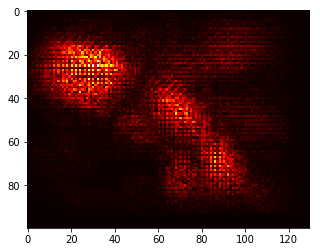

In [339]:
cri = nn.CrossEntropyLoss()
loss=cri(b,torch.tensor([0]).cuda())
loss.backward()
vis=i.grad.data.cpu().numpy()
#vis[vis>=0]=0
vis=np.abs(vis)
#vis=(vis-np.min(vis))/(np.max(vis)-np.min(vis))*255
#vis=vis-np.mean(vis)
#vis=vis.astype('uint8')
print(vis.shape)
vis=vis.squeeze()
print(vis.shape)
vis=np.transpose(vis,[1,2,0])
print(vis.shape)
vis=np.max(vis,2)
print(vis.shape)
#np.all(vis<=255)
#vis = cv2.cvtColor(vis,cv2.COLOR_RGB2GRAY)
'''cv2.imshow('vis',vis)
cv2.waitKey(0)
cv2.destroyAllWindows()'''
plt.imshow(vis, cmap=plt.cm.hot)
#plt.gcf().set_size_inches(12, 5)
plt.show()